In [1]:
import math
import numpy as np
import scipy
from scipy.fft import dct
import matplotlib.pyplot as plt
from idesolver import IDESolver

import torch
from torch import nn
import torch.optim as optim

from volterra import *
from probability import *
from transforms import *

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Plot $\mathcal{B}_\mathbb{R}$ map between $(\lambda, c_0=1, c_1=1)$ and $(\mu, \zeta_0=0, \zeta_1=0)$

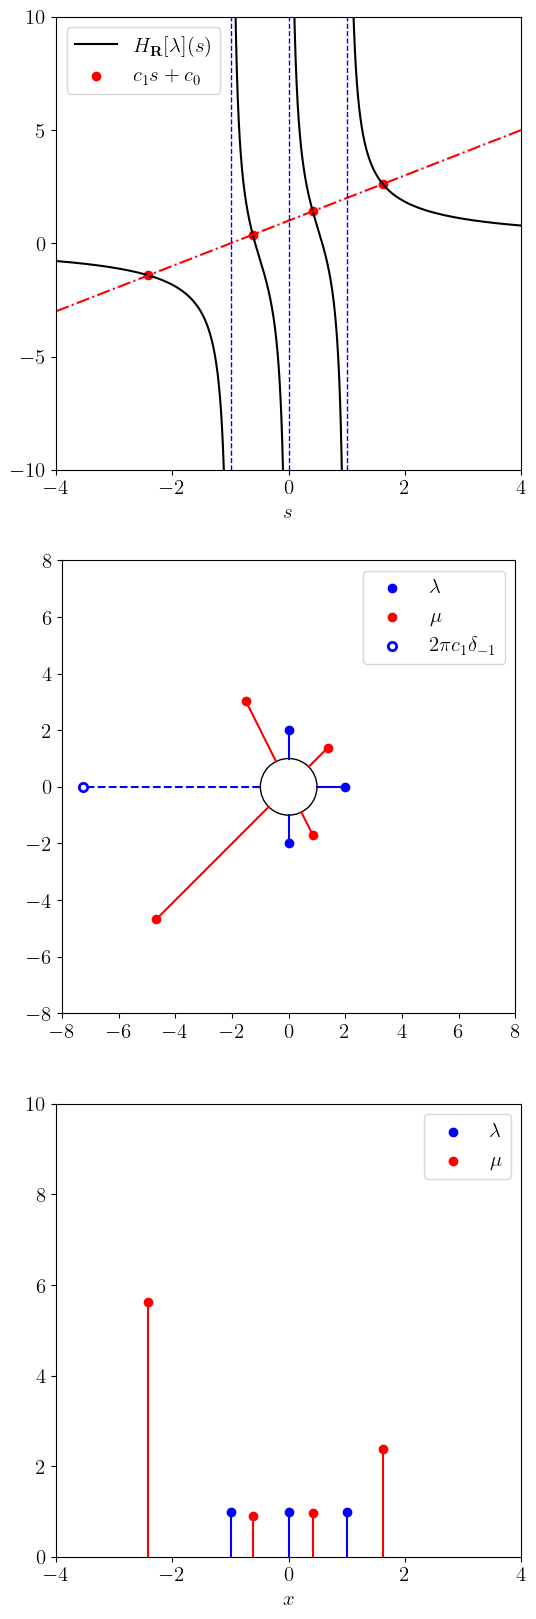

In [ ]:
x = np.linspace(-4, 4, 10000)

N = 3
a = np.array([-1, 0, 1])
b = np.ones(N)

c1 = 1
c0 = 1

zeta0, zeta1, alpha, beta = B_R_discrete(c0, c1, a, b)

Hf = np.sum(b[None, :]/(x[:, None] - a[None, :]), azetas=1)
Hf[np.where(np.diff(Hf) > 0)] = np.nan

M = N-1 + (c0 != 0) + (c1 > 0)

fig, axs = plt.subplots(3, 1, figsize=(6, 20))
axs[0].plot(x, Hf, color="k", label="$H_{\mathbf{R}}[\lambda](s)$")
axs[0].plot(x, c1*x+c0, color="red", linestyle="dashdot")
axs[0].scatter(alpha, c1*alpha+c0, color="red", label="$c_1s + c_0$")
axs[0].vlines(a, -10, 10, color="blue", linestyle="dashed", linewidth=1)
axs[0].set_xlabel("$s$")
axs[0].set_xticks(np.arange(-4, 5, 2))
axs[0].set_yticks(np.arange(-10, 11, 5))
axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-10, 10)
axs[0].legend()
#axs[0].set_aspect(1/3)

theta = mobius_inv(a)
phi = mobius_inv(alpha)

width = 8
scale = 1

circle = plt.Circle((0, 0), 1, color='black', fill=False)
axs[1].scatter((scale*b+1)*np.cos(theta), (scale*b+1)*np.sin(theta), zorder=10, color="blue", label="$\lambda$")
axs[1].scatter((scale*beta+1)*np.cos(phi), (scale*beta+1)*np.sin(phi), zorder=10, color="red", label="$\mu$")
for i in range(N):
    axs[1].plot(np.array([1, scale*b[i]+1])*np.cos(theta[i]), np.array([1, scale*b[i]+1])*np.sin(theta[i]), color="blue")
if c1 > 0:
    axs[1].scatter(-scale*2*np.pi*c1-1, 0, facecolors='white', edgecolors='blue', linewidth=2, zorder=10, label="$2\pi c_1\delta_{-1}$")
    axs[1].plot(np.array([-1, -scale*2*np.pi*c1-1]), [0, 0], color="blue", linestyle="--")
for i in range(len(beta)):
    axs[1].plot(np.array([1, scale*beta[i]+1])*np.cos(phi[i]), np.array([1, scale*beta[i]+1])*np.sin(phi[i]), color="red")
axs[1].add_patch(circle)
axs[1].set_xticks(np.arange(-width, width+1, 2))
axs[1].set_yticks(np.arange(-width, width+1, 2))
axs[1].set_xlim(-width, width)
axs[1].set_ylim(-width, width)
axs[1].set_aspect('equal')
axs[1].legend()

axs[2].scatter(a, b, color="blue", label="$\lambda$")
axs[2].vlines(a, 0, b, color="blue")
axs[2].scatter(alpha, beta, color="red", label="$\mu$")
axs[2].vlines(alpha, 0, beta, color="red")
axs[2].set_xlabel("$x$")
axs[2].set_xticks(np.arange(-4, 5, 2))
axs[2].set_yticks(np.arange(-10, 11, 2))
axs[2].set_xlim(-4, 4)
axs[2].set_ylim(0, 10)
axs[2].legend()

#plt.savefig("fig.pdf")
plt.show()

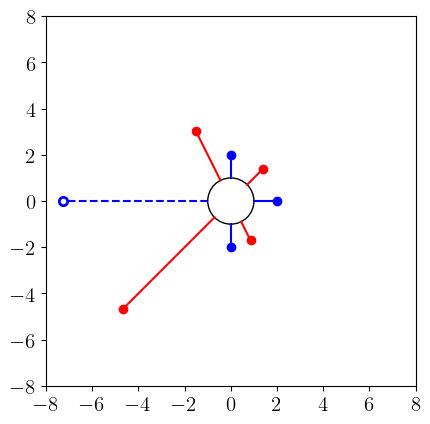

In [3]:
theta = mobius_inv(a)
phi = mobius_inv(alpha)

width = 8
scale = 1

fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.scatter((scale*b+1)*np.cos(theta), (scale*b+1)*np.sin(theta), zorder=10, color="blue")
ax.scatter((scale*beta+1)*np.cos(phi), (scale*beta+1)*np.sin(phi), zorder=10, color="red")
for i in range(N):
    ax.plot(np.array([1, scale*b[i]+1])*np.cos(theta[i]), np.array([1, scale*b[i]+1])*np.sin(theta[i]), color="blue")
ax.scatter(-scale*2*np.pi*c1-1, 0, facecolors='white', edgecolors='blue', linewidth=2, zorder=10)
if c1 > 0:
    ax.plot(np.array([-1, -scale*2*np.pi*c1-1]), [0, 0], color="blue", linestyle="--")
for i in range(len(beta)):
    ax.plot(np.array([1, scale*beta[i]+1])*np.cos(phi[i]), np.array([1, scale*beta[i]+1])*np.sin(phi[i]), color="red")
ax.add_patch(circle)
ax.set_xticks(np.arange(-width, width+1, 2))
ax.set_yticks(np.arange(-width, width+1, 2))
ax.set_xlim(-width, width)
ax.set_ylim(-width, width)
ax.set_aspect('equal')
plt.show()

### Show continuity of map $\mathcal{B}_\mathbb{R}[\lambda_n, c_0=0, c_1=0] \to \mathcal{B}_\mathbb{R}[\lambda, c_0=0, c_1=0]$

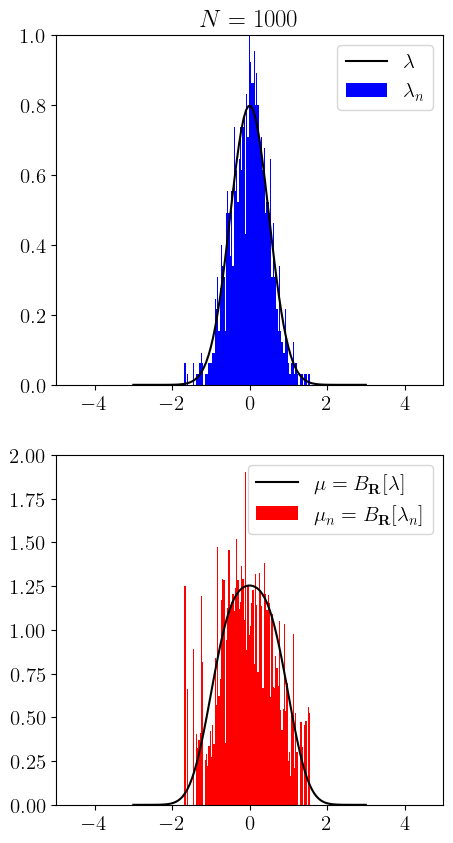

In [ ]:
N = 1000
lower = -3
upper = 3
mu = 0
sigma = 1/2
X = scipy.stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
a = X.rvs(N)
b = np.ones(N)/N

x = np.linspace(lower, upper, 100)
dx = x[1] - x[0]
f = np.exp(-(x - mu)**2/(2*sigma**2))
f /= np.sum(f) * dx

c0 = 0
c1 = 0

zeta0, zeta1, alpha, beta = B_R_discrete(c0, c1, a, b)

Hf = hilbert_transform(f, x, dx)


bins = 100

fig, axs = plt.subplots(2, 1, figsize=(5, 10))

hist, bin_edges = np.histogram(a, weights=b, bins=bins)
axs[0].bar(x=bin_edges[:-1], height=hist/np.diff(bin_edges), width=np.diff(bin_edges), color="blue", align='edge', label="$\lambda_n$")
axs[0].plot(x, f, color="k", label="$\lambda$")
axs[0].set_xlim(lower-2, upper+2)
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_title(f"$N = {N}$")

hist, bin_edges = np.histogram(alpha, weights=beta, bins=bins)
axs[1].bar(x=bin_edges[:-1], height=hist/np.diff(bin_edges), width=np.diff(bin_edges), color="red", align='edge', label="$\mu_n = B_{\mathbf{R}}[\lambda_n]$")
axs[1].plot(x, f/(f**2+(Hf-c1*x-c0)**2), color="k", label="$\mu = B_{\mathbf{R}}[\lambda]$")
axs[1].set_xlim(lower-2, upper+2)
axs[1].set_ylim(0, 2)
axs[1].legend()

plt.show()

performing discrete root-finding


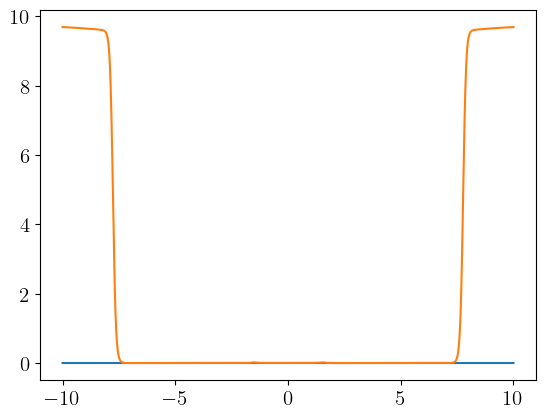

In [3]:
c0 = 0
c1 = 1

lmbda_a = np.linspace(-10, 10, 10000)
lmbda_b = np.exp(-lmbda_a**2)*(lmbda_a[1] - lmbda_a[0])

eps = 0 #1e-10
lmbda_a = lmbda_a[lmbda_b > eps]
lmbda_b = lmbda_b[lmbda_b > eps]
mu_alpha, mu_beta, zeta0, zeta1 = B_real_discrete(lmbda_a, lmbda_b, c0, c1)

plt.plot(lmbda_a, lmbda_b)
plt.plot(mu_alpha, mu_beta)
plt.show()

In [ ]:
np.sum(lmbda_b[:, None]/(lmbda_a[:, None] - mu_alpha[None, :])**2, axis=0)

array([0.0179973 , 0.01800461, 0.01801193, ..., 0.01801193, 0.01800461,
       0.0179973 ])

In [ ]:
plt.plot(lmbda_b)
plt.yscale("log")
plt.show()